In [1]:
from all_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from mango import scheduler, Tuner

def objective(args_list):
    global train_v_data, train_v_real, test_v_data, test_v_real
    results = []
    params_evaluated = []
    for params in args_list:
        try:
            predictor = DeepAREstimator(
                prediction_length=12, freq="M", 
                context_length = int(params['context_length']),
                num_layers=params["num_layers"],
                # hidden_size=params["hidden_size"],
                batch_size= int(params['mini_batch_size']),
                dropout_rate = params['dropout_rate'],
                # num_cells = int(params['num_cells']),
                # num_layers = int(params['num_layers']),
                # embedding_dimension = int(params['embedding_dimension']),
                trainer_kwargs={
                    # "learning_rate": params['learning_rate'],
                    "accelerator": "gpu",
                    "enable_progress_bar": False,
                    "enable_model_summary": False,
                    "max_epochs": 50
                    # "mini_batch_size": int(params['mini_batch_size']),
                    }
            ).train(train_v_data)
            
            forecast_it = list(predictor.predict(test_v_data.input, num_samples=100))

            all_forecasts = []
            for forecast in forecast_it:
                all_forecasts.append(forecast.mean)
            
            _, mean, std = rolling_window_series(train_v_real, 12)
            preds_real = znorm_reverse(all_forecasts[0], mean, std)

            rmse_result = rmse(test_v_real, preds_real)
            params_evaluated.append(params)
            results.append(rmse_result)
        except:
            continue
    return results


def find_best_parameter(train_norm, test_norm, train_real, test_real):
    global train_v_data, train_v_real, test_v_data, test_v_real

    params_space = {
        'context_length': range(1,200),
        # 'learning_rate': np.logspace(-5, -1, 10),
        'mini_batch_size': range(32, 1029, 32),
        # 'num_cells': range(30, 201, 10),
        'num_layers': range(1, 9),
        'dropout_rate': np.linspace(0.0, 0.2, 5),
        # 'embedding_dimension': range(1, 51)
    }
    conf_Dict = dict()
    conf_Dict['num_iteration'] = 15
    train_v_data = train_norm
    train_v_real = train_real
    test_v_data = test_norm
    test_v_real = test_real

    tuner = Tuner(params_space, objective, conf_Dict)
    results_arima = tuner.minimize()

    return results_arima

def get_train_test_deepar(train_norm, test_norm):
    concat_norm = pd.concat([train_norm, test_norm])
    dataset_norm = PandasDataset(concat_norm, target="value")
    # test_ds = PandasDataset(test_norm, target="value")
    training_data, test_gen = split(dataset_norm, offset=-12)
    test_data = test_gen.generate_instances(prediction_length=12, windows=1)
    return training_data, test_data

/home/anp/anaconda3/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
global horizon
window = 12
horizon = 12
derivado = "gasolinac"
estado = "SP"
df = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(df, horizon)
train_val, test_val = train_test_stats(train, horizon)

#treino
train_tf, mean, std = rolling_window_series(train, horizon)
test_tf = znorm_mean_std(test, mean, std)
train_data, test_data = get_train_test_deepar(train_tf, test_tf)

#validacao
train_val_tf, mean_val, std_val = rolling_window_series(train_val, horizon)
test_val_tf = znorm_mean_std(test_val, mean_val, std_val)
train_data_val, test_data_val = get_train_test_deepar(train_val_tf, test_val_tf)

results = find_best_parameter(train_data_val, test_data_val, train_val, test_val)

predictor = DeepAREstimator(
        prediction_length=12,
        context_length = int(results['best_params']['context_length']),
        num_cells = int(results['best_params']['num_cells']),
        num_layers = int(results['best_params']['num_layers']),
        embedding_dimension = int(results['best_params']['embedding_dimension']),

        prediction_length=12, freq="M", 
        trainer_kwargs={
            "learning_rate": results['best_params']['learning_rate'],
            "max_epochs": 100,
            "batch_size": int(results['best_params']['mini_batch_size']),
            "num_batches_per_epoch": results['best_params']['num_batches_per_epoch'],
            "dropout_rate": results['best_params']['dropout_rate']
            }
    ).train(train_data)
forecasts_it = list(predictor.predict(test_data.input, num_samples=100))
all_forecasts = []
for forecast in forecasts_it:
    all_forecasts.append(forecast.mean)

reversed = znorm_reverse(all_forecasts[0], mean, std)
print(reversed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-08-15 01:54:11.218419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 01:54:12.365111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU av

In [ ]:
plt.plot(reversed, label='Predição')
plt.plot(test_val.values, label='Valores Reais')
plt.legend()
plt.show()

In [ ]:
# train_tf = transform_train(train, format="normal")
train_norm, mean, std = rolling_window_series(train, horizon)
test_norm = znorm_mean_std(test, mean, std)
concat_norm = pd.concat([train_norm, test_norm])
dataset_norm = PandasDataset(concat_norm, target="value")
# test_ds = PandasDataset(test_norm, target="value")
training_data, test_gen = split(dataset_norm, offset=-12)
test_data = test_gen.generate_instances(prediction_length=12, windows=1)
model = DeepAREstimator(
    prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 50}
).train(training_data)
forecasts_it = list(model.predict(test_data.input, num_samples=100))
# predictor.predict(test_data.input, num_samples=num_samples)
# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=test_ds,
#     predictor=model,
#     num_samples=100,
# )


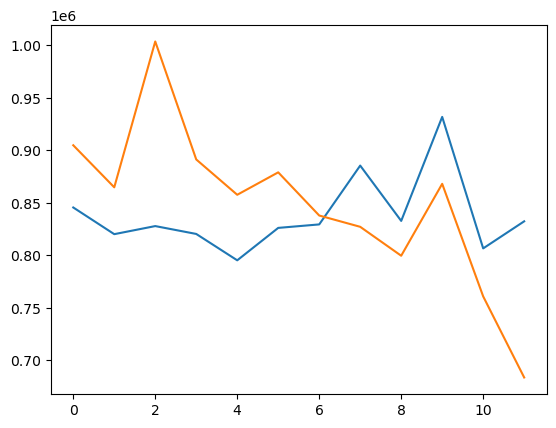

In [ ]:
all_forecasts = []
for forecast in forecasts_it:
    all_forecasts.append(forecast.mean)

preds_notrain = znorm_reverse(all_forecasts[0], mean, std)
plt.plot(preds_notrain, label='sem busca')
plt.plot(reversed, label='com busca')
plt.plot(test.values, label='Valores Reais')
plt.legend()
plt.show()